**Корректность проверена на Python 3.6:**
+ numpy 1.15.4
+ matplotlib 3.0.2
+ pandas 0.23.4


# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('bikes_rent.csv')

In [3]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

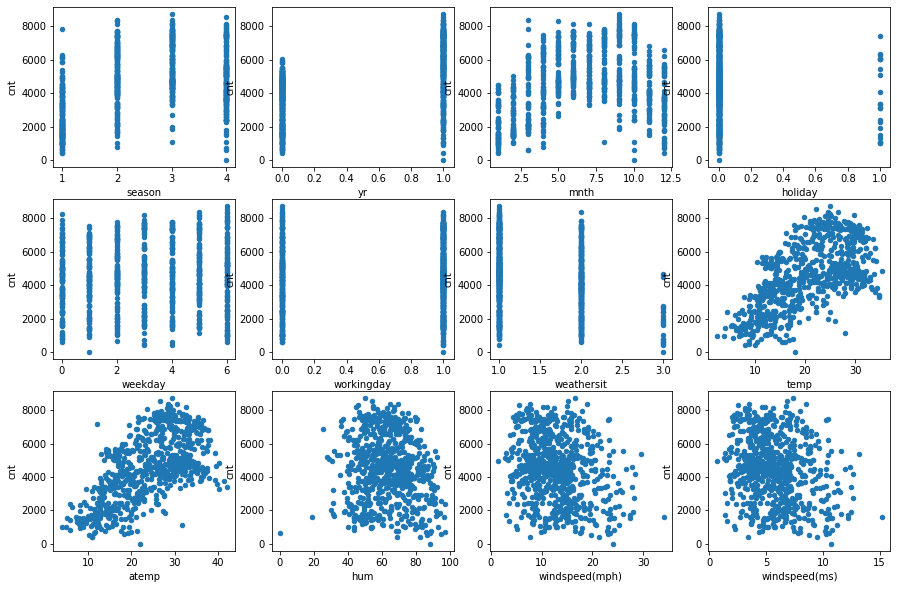

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: криволинейная.
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: температура по ощущениям в Цельсиях, температура в Цельсиях.

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [5]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:df_
data = df.drop('cnt', axis=1)
correlation = data.corrwith(other=df.cnt)

In [6]:
correlation

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [7]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)','cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [8]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [9]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [10]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [13]:
def print_coefs(coefs):
    for i, j in zip(list(df.columns), coefs):
        print(f'The weight of {i} is {j}.')

In [14]:
print_coefs(lr.coef_)

The weight of season is 570.8681698112806.
The weight of yr is 1021.9637175294769.
The weight of mnth is -141.30232005185658.
The weight of holiday is -86.76357810238395.
The weight of weekday is 137.2291962130855.
The weight of workingday is 56.38823527436251.
The weight of weathersit is -330.2316126526911.
The weight of temp is 367.4749136050979.
The weight of atemp is 585.5563613048682.
The weight of hum is -145.60790584172227.
The weight of windspeed(mph) is 12458830091266.607.
The weight of windspeed(ms) is -12458830091465.062.


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [15]:
from sklearn.linear_model import Lasso, Ridge

In [16]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса
lr_Lasso = Lasso().fit(X, y)
print_coefs(lr_Lasso.coef_)

The weight of season is 560.2416160308869.
The weight of yr is 1019.4634940657196.
The weight of mnth is -128.7306270367875.
The weight of holiday is -86.1527813337111.
The weight of weekday is 137.34789390496312.
The weight of workingday is 55.21237064135672.
The weight of weathersit is -332.3698569623486.
The weight of temp is 376.3632362096987.
The weight of atemp is 576.530793504551.
The weight of hum is -144.12915500348606.
The weight of windspeed(mph) is -197.1396894024858.
The weight of windspeed(ms) is -2.8049811945715987e-08.


In [17]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса
lr_Ridge = Ridge().fit(X, y)
print_coefs(lr_Ridge.coef_)

The weight of season is 563.0645722520169.
The weight of yr is 1018.9483787875299.
The weight of mnth is -131.87332028247644.
The weight of holiday is -86.74609799709228.
The weight of weekday is 138.00511117871906.
The weight of workingday is 55.903110375064735.
The weight of weathersit is -332.34978849907395.
The weight of temp is 386.45788919191244.
The weight of atemp is 566.3470470600627.
The weight of hum is -145.07132729867166.
The weight of windspeed(mph) is -99.25944108182091.
The weight of windspeed(ms) is -99.2594411543116.


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [18]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.
for i, alpha in enumerate(alphas):
    lr_Lasso = Lasso(alpha=alpha).fit(X, y)
    coefs_lasso[i,:] =  lr_Lasso.coef_
    lr_Ridge = Ridge(alpha=alpha).fit(X, y)
    coefs_ridge[i,:] = lr_Ridge.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

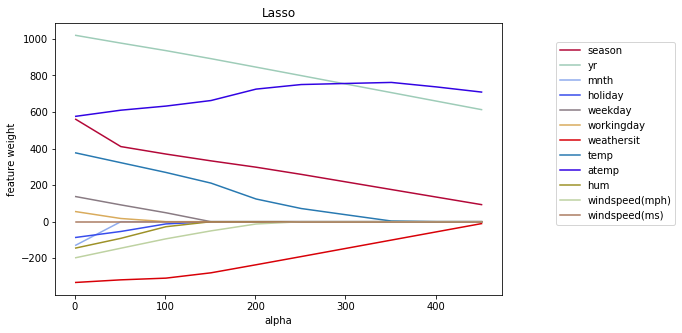

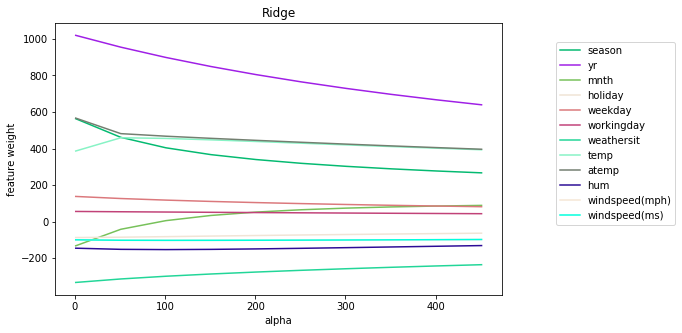

In [19]:
plt.figure(figsize=(8, 5))
windLasso = []
fLasso = []
yrLasso = []
f = []
for coef, feature in zip(coefs_lasso.T, df.columns):
    if feature == 'windspeed(mph)' or feature == 'windspeed(ms)':
        windLasso.append(coef)
        fLasso.append(feature)
    if feature == 'yr':
        yrLasso.append(coef)
        f.append(feature)
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
windRidge = []
fRidge = []
yrRidge = []

for coef, feature in zip(coefs_ridge.T, df.columns):
    if feature == 'windspeed(mph)' or feature == 'windspeed(ms)':
        windRidge.append(coef)
        fRidge.append(feature)
    if feature == 'yr':
        yrRidge.append(coef)
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

In [20]:
def print_weights(features, weights):
    for i in range(len(features)):
        print(f'Feature is {features[i]}:')
        for alpha, weight in zip(alphas, weights[i]):
            print(f'alpha = {alpha}, weight = {weight}')
        print('')

Рассмотрим признаки с малыми весами и влияние величины коэффициента регуляризации на них.

In [21]:
#1 распечатка
print_weights(fLasso, windLasso)

Feature is windspeed(mph):
alpha = 1, weight = -197.1396894024858
alpha = 51, weight = -145.0660953796706
alpha = 101, weight = -93.77490365961356
alpha = 151, weight = -50.15514715907755
alpha = 201, weight = -12.646176867013196
alpha = 251, weight = -0.0
alpha = 301, weight = -0.0
alpha = 351, weight = -0.0
alpha = 401, weight = -0.0
alpha = 451, weight = -0.0

Feature is windspeed(ms):
alpha = 1, weight = -2.8049811945715987e-08
alpha = 51, weight = -2.2988124316107237e-08
alpha = 101, weight = -2.4164779042944866e-08
alpha = 151, weight = -2.6276777530275033e-08
alpha = 201, weight = -2.787812522494027e-08
alpha = 251, weight = -0.0
alpha = 301, weight = -0.0
alpha = 351, weight = -0.0
alpha = 401, weight = -0.0
alpha = 451, weight = -0.0



In [22]:
#2 распечатка
print_weights(fRidge, windRidge)

Feature is windspeed(mph):
alpha = 1, weight = -99.25944108182091
alpha = 51, weight = -101.62731482450901
alpha = 101, weight = -102.10167084196222
alpha = 151, weight = -102.0053759248015
alpha = 201, weight = -101.58638458309962
alpha = 251, weight = -100.96471143218771
alpha = 301, weight = -100.20862040628761
alpha = 351, weight = -99.3606611678625
alpha = 401, weight = -98.44906427000382
alpha = 451, weight = -97.4934336162151

Feature is windspeed(ms):
alpha = 1, weight = -99.2594411543116
alpha = 51, weight = -101.62731482566231
alpha = 101, weight = -102.10167084246358
alpha = 151, weight = -102.00537592509896
alpha = 201, weight = -101.58638458330087
alpha = 251, weight = -100.96471143233572
alpha = 301, weight = -100.20862040640162
alpha = 351, weight = -99.36066116795364
alpha = 401, weight = -98.44906427007892
alpha = 451, weight = -97.49343361627835



Теперь с большими (порядка 10^3).

In [23]:
#3 распечатка
print_weights(f,yrLasso)

Feature is yr:
alpha = 1, weight = 1019.4634940657196
alpha = 51, weight = 977.0194092077683
alpha = 101, weight = 935.9454895153195
alpha = 151, weight = 891.8700581130523
alpha = 201, weight = 845.65285736485
alpha = 251, weight = 799.2372725164988
alpha = 301, weight = 752.7208084845753
alpha = 351, weight = 706.2037880222196
alpha = 401, weight = 659.6325347207692
alpha = 451, weight = 613.0546392223404



In [24]:
#4 распечатка
print_weights(f, yrRidge)

Feature is yr:
alpha = 1, weight = 1018.9483787875299
alpha = 51, weight = 954.3077418886561
alpha = 101, weight = 898.083622120892
alpha = 151, weight = 848.4634647099278
alpha = 201, weight = 804.2510479702987
alpha = 251, weight = 764.561433696155
alpha = 301, weight = 728.7085401826953
alpha = 351, weight = 696.1458164589899
alpha = 401, weight = 666.4297472104463
alpha = 451, weight = 639.1953675461727



Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: из распечаток пар 1 и 2, 3 и 4 видно, что Lasso агрессивнее уменьшает веса.
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: зануляются малоинформативные признаки, такие как windspeed, потому что регуляризатор Lasso уменьшает абсолютное значение коэффициентов. Подробнее: https://clck.ru/VUgMW (Курс "Машинное обучение 1", ПМИ ФКН ВШЭ, Лектор — Евгений Соколов).
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: Как видно из распечатки 1 и 2 -- регуляризатор Lasso исключил признаки при alpha >= 251, т.е: исключает признаки не при любом значении alpha > 0. Ridge не исключает вовсе.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: Lasso.

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [25]:
from sklearn.linear_model import LassoCV

In [26]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
alphas = np.arange(1, 100, 5)
reg = LassoCV(alphas=alphas, cv=3, random_state=0).fit(X, y)

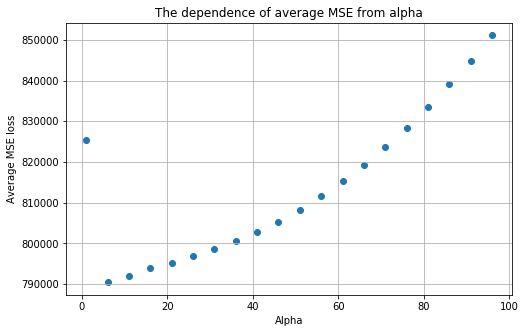

In [27]:
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
plt.figure(figsize=(8, 5))
plt.scatter(reg.alphas_, reg.mse_path_.mean(axis=1))
plt.title("The dependence of average MSE from alpha")
plt.xlabel("Alpha")
plt.ylabel("Average MSE loss")
plt.grid()


In [28]:
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
print('Alpha is', reg.alpha_)
for coef, feature in zip(reg.coef_, df.columns):
    print(f'Weight of {feature} is {coef}')

Alpha is 6
Weight of season is 532.0189828413535
Weight of yr is 1015.0602226430601
Weight of mnth is -100.0395261435663
Weight of holiday is -83.29395987529922
Weight of weekday is 132.50446549095798
Weight of workingday is 51.55708561407379
Weight of weathersit is -330.55985673998146
Weight of temp is 370.6798550300354
Weight of atemp is 581.3969310654965
Weight of hum is -140.00740550068858
Weight of windspeed(mph) is -191.7714084713507
Weight of windspeed(ms) is -2.6854541815693778e-08


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

In [29]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
ind_min_alphas = [np.argmin(elem) for elem in reg.mse_path_.T]

for i, ind in enumerate(ind_min_alphas):
    print(f'Минимальное значение для {i}ой колонки: {reg.alphas_[ind]}.')

Минимальное значение для 0ой колонки: 41.
Минимальное значение для 1ой колонки: 6.
Минимальное значение для 2ой колонки: 1.


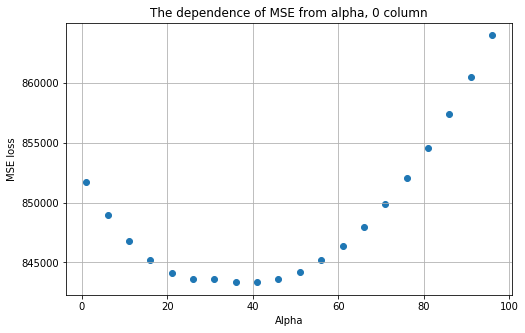

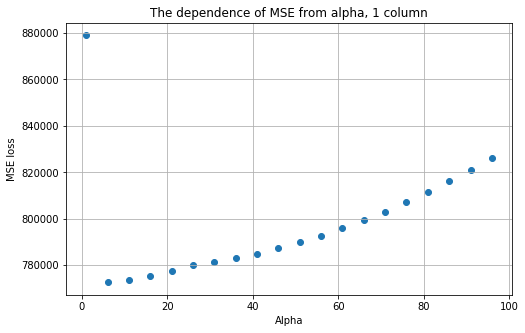

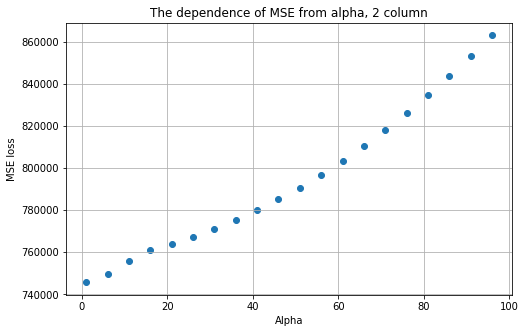

In [30]:
# На трех отдельных графиках визуализируйте столбцы .mse_path_
for num, loss in enumerate(reg.mse_path_.T):
    plt.figure(figsize=(8, 5))
    plt.scatter(reg.alphas_, loss)
    plt.title(f'The dependence of MSE from alpha, {num} column')
    plt.xlabel("Alpha")
    plt.ylabel("MSE loss")
    plt.grid()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 3. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: 4 признака с наибольшими (положительными) коэфициентами -- 'season', 'yr', 'temp', 'atemp'. Заметим, что для 'temp', 'atemp', 'yr' наблюдается возрастающая линейная зависимость, 'season' то же можно описать возрастающей линейной зависимость, но более точно -- криволиной (зимой спрос на велосипеды падает). В общем случае логично утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды, пример: чем лучше погода, тем больше хочется кататься на велосипедах, тем чаще берут велосипеды.
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: 3 признака с наибольшими по модулю отрицательными коэффициентами --'weathersit', 'hum', 'windspeed(mph)' показывают убывающую линейную зависимость. Логично утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды, пример: чем хуже погода, тем меньше хочется кататься на велосипедах, тем реже берут велосипеды.
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: коэффициенты признака windspeed(ms) близок к нулю. Избыточен (есть windspeed(mph)), поэтому модель исключила признак.

In [31]:
#1 вопрос
max_coef = sorted(reg.coef_)[-4:]
max_f = []

In [32]:
for coef, feature in zip(reg.coef_, df.columns):
    if coef in max_coef:
        max_f.append(feature)
        print(f'Одному из максимальныйх значений {coef} соответсвует {feature} признак.')

Одному из максимальныйх значений 532.0189828413535 соответсвует season признак.
Одному из максимальныйх значений 1015.0602226430601 соответсвует yr признак.
Одному из максимальныйх значений 370.6798550300354 соответсвует temp признак.
Одному из максимальныйх значений 581.3969310654965 соответсвует atemp признак.


In [33]:
max_f 

['season', 'yr', 'temp', 'atemp']

In [34]:
#2 вопрос
min_coef = sorted(reg.coef_)[:3]
min_f = []

In [35]:
for coef, feature in zip(reg.coef_, df.columns):
    if coef in min_coef:
        min_f.append(feature)
        print(f'Одному из минимальных значений {coef} соответсвует {feature} признак.')

Одному из минимальных значений -330.55985673998146 соответсвует weathersit признак.
Одному из минимальных значений -140.00740550068858 соответсвует hum признак.
Одному из минимальных значений -191.7714084713507 соответсвует windspeed(mph) признак.


In [36]:
min_f

['weathersit', 'hum', 'windspeed(mph)']

In [37]:
#3 вопрос
zero = [elem for elem in sorted(reg.coef_) if abs(elem) <= 1e-3]

In [38]:
for coef, feature in zip(reg.coef_, df.columns):
    if coef in zero:
        print(f'Близкому к нулю значению {coef} соответсвует {feature} признак.')

Близкому к нулю значению -2.6854541815693778e-08 соответсвует windspeed(ms) признак.


### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.